### Profiling JAX HPC Profiler with Timer and Visualization Tools

This notebook demonstrates how to use the `jax_hpc_profiler` package for performance profiling of JAX and NumPy functions. The workflow includes benchmarking, generating CSV reports, and visualizing weak scaling results.



In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax_hpc_profiler import Timer

### **Defining JAX and NumPy Functions**

This cell defines computational functions for matrix operations. JAX functions utilize `@jax.jit` for just-in-time compilation, while equivalent NumPy functions serve as benchmarks for comparison.

In [ ]:
# Define JAX functions
@jax.jit
def mma(m, n, k):
    return jnp.dot(m, n) + k

@jax.jit
def inv(m):
    return jnp.linalg.inv(m)

# Define NumPy functions
def numpy_mma(m, n, k):
    return np.dot(m, n) + k

def numpy_inv(m):
    return np.linalg.inv(m)

### **Profiling JAX and NumPy Functions Across Matrix Sizes**

This cell initializes two `Timer` objects from the `jax_hpc_profiler` package for profiling JAX and NumPy functions. A range of matrix sizes, from 100x100 to 1000x1000, is evaluated to compare the performance of JAX and NumPy implementations of matrix operations.

- **JAX Profiling**:  
  The JAX timer measures the execution time of just-in-time compiled (`@jax.jit`) functions for matrix multiplication-addition (`mma`) and matrix inversion (`inv`). The results are saved in a `JAX.csv` file with metadata.

- **NumPy Profiling**:  
  The NumPy timer benchmarks the equivalent operations using standard NumPy functions. Execution times are saved in a `NUMPY.csv` file for comparison.

Both profiling workflows repeat each operation 10 times for more reliable measurements, and results are reported with associated metadata such as matrix size and precision.

In [7]:
# Initialize timers
jax_timer = Timer(save_jaxpr=True, jax_fn=True)
numpy_timer = Timer(save_jaxpr=False, jax_fn=False)

# Profiling matrix sizes from 100x100 to 1000x1000
for size in range(100, 1001, 100):
    # JAX Matrices
    m_jax = jnp.ones((size, size))
    n_jax = jnp.ones((size, size))
    k_jax = jnp.ones((size, size))
    rand_jax = jax.random.normal(jax.random.key(0), (size, size))
    
    # NumPy Matrices
    m_np = np.ones((size, size))
    n_np = np.ones((size, size))
    k_np = np.ones((size, size))
    rand_np = np.random.rand(size, size)

    # --- JAX profiling ---
    jax_timer.chrono_jit(mma, m_jax, n_jax, k_jax)
    for _ in range(10):
        jax_timer.chrono_fun(mma, m_jax, n_jax, k_jax)

    kwargs = {"function": "mma", "precision": "float32", "x": size, "y": size}
    extra_info = {"done": "yes"}
    jax_timer.report("JAX.csv", **kwargs, extra_info=extra_info)

    jax_timer.chrono_jit(inv, rand_jax)
    for _ in range(10):
        jax_timer.chrono_fun(inv, rand_jax)

    kwargs = {"function": "inv", "precision": "float32", "x": size, "y": size}
    jax_timer.report("JAX.csv", **kwargs, extra_info=extra_info)

    # --- NumPy profiling ---
    numpy_timer.chrono_jit(numpy_mma, m_np, n_np, k_np)
    for _ in range(10):
        numpy_timer.chrono_fun(numpy_mma, m_np, n_np, k_np)

    kwargs = {"function": "mma", "precision": "float32", "x": size, "y": size}
    numpy_timer.report("NUMPY.csv", **kwargs, extra_info=extra_info)

    numpy_timer.chrono_jit(numpy_inv, rand_np)
    for _ in range(10):
        numpy_timer.chrono_fun(numpy_inv, rand_np)

    kwargs = {"function": "inv", "precision": "float32", "x": size, "y": size}
    numpy_timer.report("NUMPY.csv", **kwargs, extra_info=extra_info)


### **Visualizing Weak Scaling Performance**  

This cell uses `jax_hpc_profiler.plotting` to generate a weak scaling visualization from the profiling results stored in `NUMPY.csv` and `JAX.csv`. 

- **Weak Scaling**:  
  Measures performance as the problem size increases proportionally to the available resources, helping to evaluate scalability.

- **Plot Customization**:  
  - Labels for the plot are dynamically generated using placeholders like `%m%` for the method name and `%f%` for function details (run `jhp label_help` for more info).


requested GPUS: None available GPUS: {1}
requested data sizes: None available data sizes: {800, 100, 900, 200, 1000, 300, 400, 500, 600, 700}


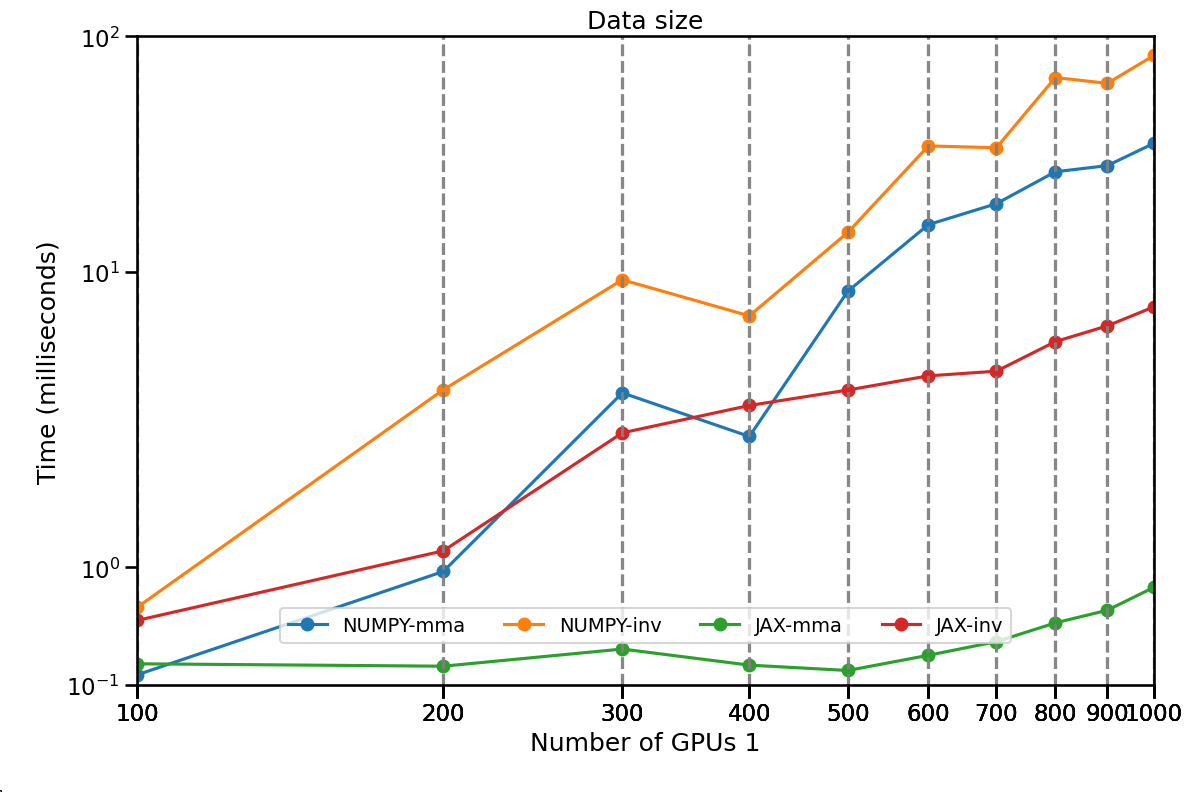

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from jax_hpc_profiler.plotting import plot_weak_scaling , plot_strong_scaling

plt.rcParams.update({'font.size': 15})

sns.set_context("talk")

csv_file = ["NUMPY.csv", "JAX.csv"]

plot_weak_scaling(
    csv_files=csv_file,
    figure_size=(12, 8),
    label_text="%m%-%f%"
)

### **Filtering Options for Weak Scaling Visualization**

This cell demonstrates how to use the `plot_weak_scaling` function to filter and visualize specific data points. You can filter by various parameters, such as data size, GPU configurations, functions, precisions, and more, to customize your weak scaling analysis.  

For example:
- `fixed_data_size` is used here to limit the visualization to specific matrix sizes (100 to 700 in steps of 100).
- Additional options include filtering by GPU size, precision, and decomposition strategy.

Check the function's docstring for a full list of parameters and detailed usage information.

requested GPUS: None available GPUS: {1}
requested data sizes: [100, 200, 300, 400, 500, 600, 700] available data sizes: {100, 200, 300, 400, 500, 600, 700}


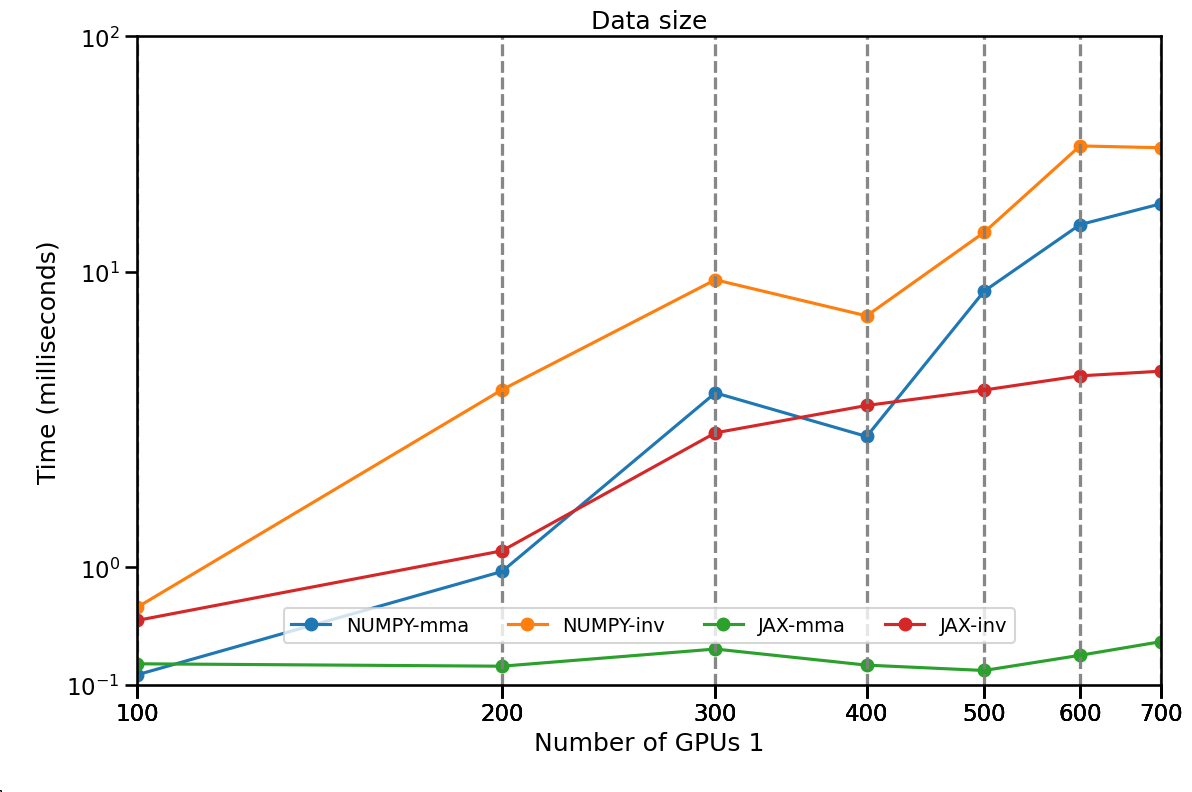

In [20]:

import seaborn as sns
import matplotlib.pyplot as plt
from jax_hpc_profiler.plotting import plot_weak_scaling , plot_strong_scaling

plt.rcParams.update({'font.size': 15})

sns.set_context("talk")

csv_file = ["NUMPY.csv", "JAX.csv"]

plot_weak_scaling(
    csv_files=csv_file,
    fixed_data_size=np.arange(100, 701, 100).tolist(),
    figure_size=(12, 8),
    label_text="%m%-%f%"
)

### **Weak Scaling Plot via Command Line**

You can also generate weak scaling plots directly from the command line using the `jhp plot` command. For example:

```bash
!jhp plot -f NUMPY.csv JAX.csv -d 100 200 300 -sc w -pt mean_time -o weak_scaling.png -l "%m%-%f%"
```

This command allows you to:
- Filter by data sizes (`-d 100 200 300`).
- Plot using weak scaling (`-sc w`).
- Select the `mean_time` for plotting (`-pt mean_time`).
- Save the plot as `weak_scaling.png` (`-o weak_scaling.png`).

For more options, check the function's docstring or use the help command.

In [25]:
!jhp plot -f NUMPY.csv JAX.csv -d 100 200 300 -sc w -pt mean_time -o weak_scaling.png -l "%m%-%f%"

/home/wassim/micromamba/envs/jax/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


requested GPUS: None available GPUS: {1}
requested data sizes: [100, 200, 300] available data sizes: {200, 100, 300}


### **Handling Multiple Outputs in JAX Functions**

When profiling JAX functions that return multiple outputs, it’s important to select which argument to use with `block_until_ready` to ensure accurate timing.

In cases where a JAX function has multiple outputs, specifying the `ndarray_arg` parameter is necessary. This indicates which argument to block until the operation is completed. For example, by selecting the first output, the profiler ensures that it waits for the entire computation to finish, not just the first operation.

Check the JAX documentation for more details on handling multi-output functions.

In [26]:
@jax.jit
def multi_out(x , y):
    return x + y , x - y


timer = Timer()

timer.chrono_jit(multi_out, 1, 2 , ndarray_arg=0)

(Array(3, dtype=int32, weak_type=True), Array(-1, dtype=int32, weak_type=True))